In [1]:
import pickle
import numpy as np
import torch
import sys

sys.path.insert(0, '/research/iprobe-ashbau12/repos/outside/OpenGait/opengait/')
from utils.evaluation import cuda_dist

In [5]:
test_metric_file = "./accuracy_and_seqs_all_ordered_s2s_open.pkl"


In [ ]:
with open(test_metric_file, "rb") as f:
    probe_seqs = pickle.load(f)                                 
    gallery_seqs = pickle.load(f)                               
    seq_type = pickle.load(f)
    acc = pickle.load(f)
    gallery_y = pickle.load(f)
    label = pickle.load(f)
    probe_sequence_label_mask = pickle.load(f)
    gallery_labels = pickle.load(f)
    feature = pickle.load(f)
    to_save = pickle.load(f)

In [3]:
def load_bunch_of_variables(filename):
    with open(filename, "rb") as f:
        false_in_row_until_correct_match = pickle.load(f)
        acc = pickle.load(f)
        probe_seqs = pickle.load(f)
        gallery_seqs = pickle.load(f)                               
        seq_type = pickle.load(f)
        gallery_y = pickle.load(f)
        label = pickle.load(f)
        probe_sequence_label_mask = pickle.load(f)
        gallery_labels = pickle.load(f)
        to_save = pickle.load(f)
        all_video_fnames = pickle.load(f)
    
    return [false_in_row_until_correct_match, acc, probe_seqs, gallery_seqs, 
            seq_type, gallery_y, label, probe_sequence_label_mask, gallery_labels,
            to_save, all_video_fnames]

In [9]:
[_, acc, probe_seqs, gallery_seqs, seq_type, gallery_y, label,
 probe_sequence_label_mask, gallery_labels, to_save, _] = load_bunch_of_variables(test_metric_file)

In [10]:
# subject stuff
num_probe_subjects_with_gallery = len(set(label[probe_sequence_label_mask]))
num_gallery_subjects = len(set(gallery_labels))


print("Num. probe subjects with gallery: {}".format(num_probe_subjects_with_gallery))
print("Num. gallery subjects:            {}".format(num_gallery_subjects))
print(probe_seqs)

Num. probe subjects with gallery: 73
Num. gallery subjects:            73
[['struct', 'stand', 'rand']]


In [11]:
gallery_collapsed = []                                                      
label_collapsed = []

for l, g in to_save['gallery'].items():                                     
    label_collapsed.append(l)                                               
    gallery_collapsed.append(np.stack(g).mean(0))                           
label_collapsed = np.array(label_collapsed)                                 
gallery_collapsed = np.stack(gallery_collapsed)                             

gallery_x = gallery_collapsed                                               
gallery_y = label_collapsed   

In [12]:
all_probes = []
num_rank = 10

for (p, probe_seq) in enumerate(probe_seqs):                   
    for gallery_seq in gallery_seqs:                           
        # for (v1, probe_view) in enumerate(view_list):                     
        #     for (v2, gallery_view) in enumerate(view_list):                           
        gseq_mask = np.isin(seq_type, gallery_seq) # & np.isin(             
        #     view, [gallery_view])                                         
        '''                                                                 
        gallery_x = feature[gseq_mask, :]                                   
        gallery_y = label[gseq_mask]                                        
        '''                                                                 

        pseq_mask = np.isin(seq_type, probe_seq)                            
        # pseq_mask = np.isin(seq_type,                                     
        #                     probe_seq) & probe_sequence_label_mask        
        # & np.isin(                                                        
        #     view, [probe_view])                                           
        probe_x = feature[pseq_mask, :]                                     
        
        # tuple of probes len num_samples converted to vector
        probe_y = label[pseq_mask]
        probe_y_vector = np.reshape(probe_y, [-1, 1])
        
        # calculate distance between probe features and gallery features
        dist = cuda_dist(probe_x, gallery_x, 'cos')
        sorted_match_indices = dist.sort(1)[1].cpu().numpy() 
        
        # sort the gallery based on the sorted match scores up to max rank
        gallery_match_score_sorted = gallery_y[sorted_match_indices[:, 0:num_rank]]
        
        # then, identify locations where the correct match appears
        # (num_probes x num_rank)
        correct_match_locations = (np.reshape(probe_y, [-1, 1]) ==
                                   gallery_y[idx[:, 0:num_rank]])
        
        # find the cumulative sum along the rows (add columns). Once greater than zero
        # correct match has been found, still (num_probes x num_rank)
        false_in_rows_until_correct_match = np.cumsum(np.reshape(probe_y, [-1, 1]) ==
                                                      gallery_y[idx[:, 0:num_rank]],
                                                      1) > 0
        
        # then sum this along the columns to see how many 1's in rank-1 column, 
        # rank-5 column, etc.
        num_matches_in_given_column = np.sum(false_in_rows_until_correct_match, 0)
        
        # percentage rank-1 through rank-num_rank
        num_probes = dist.shape[0]
        rank_percentages = np.round(num_matches_in_given_column * 100 / num_probes, 2)
        
        ####
        all_probes.append(set(probe_y))

        dist = cuda_dist(probe_x, gallery_x, 'cos')                        
        idx = dist.sort(1)[1].cpu().numpy() 
        acc[p, :, :, :] = np.round(np.sum(np.cumsum(np.reshape(probe_y, [-1, 1]) == 
                                                    gallery_y[idx[:, 0:num_rank]],
                                                    1) > 0,
                                          0) * 100 / dist.shape[0],
                                   2)

NameError: name 'feature' is not defined

In [9]:
def isProbeInTopN(probe_y, gallery_y, sorted_indices, rank):
    '''
    columns are N ranks
    rows are probes
    '''
    probe_in_top_N = np.cumsum(np.reshape(probe_y, [-1, 1]) == gallery_y[sorted_indices[:, 0:rank]], 1) > 0
    return probe_in_top_N


def findCorrectMatches(probe_in_top_N):
    correct_matches = probe_in_top_N.cumsum(axis=1) == 1
    return correct_matches


def isCorrectMatchWithinRankN(correct_matches, rank):
    # be sure to pass only mated probes, since if a row that is all false will
    # have argmax return 0
    probe_match_within_rank_N = correct_matches.argmax(axis=1) < rank
    return probe_match_within_rank_N


def doesCorrectMatchScorePassThreshold(correct_match_scores, threshold):
    score_pass_threshold = correct_match_scores < threshold
    return score_pass_threshold


def sortDistances(dist, num_rank):
    ranked_distances = dist.sort(1)[0][:, 0:num_rank]
    return ranked_distances


def findProbesWithAFalsePositive(ranked_distances, rank, threshold):
    # only pass in non-mated probes
    false_positives = (ranked_distances[:, :rank].cpu().numpy() < threshold).cumsum(axis=1).cumsum(axis=1) == 1
    return false_positives

In [41]:
false_positives = findProbesWithAFalsePositive(ranked_distances[non_mated_probes_mask, :],
                                               5,
                                               0.25)
print(false_positives.sum())

215


In [37]:
np.where(~false_positives)
ranked_distances[non_mated_probes_mask, :][np.where(~false_positives)[0], :]
ranked_distances[non_mated_probes_mask, :][np.where(~false_positives)[0], :]

tensor([[0.5156, 0.5250, 0.5308, 0.5367, 0.5494, 0.5503, 0.5535, 0.5594, 0.5668,
         0.5691],
        [0.5492, 0.5638, 0.5728, 0.5735, 0.5787, 0.5867, 0.5867, 0.5895, 0.5925,
         0.5973],
        [0.6063, 0.6314, 0.6314, 0.6393, 0.6466, 0.6530, 0.6540, 0.6619, 0.6627,
         0.6627],
        [0.5110, 0.5400, 0.5441, 0.5476, 0.5686, 0.6062, 0.6157, 0.6194, 0.6595,
         0.6630],
        [0.5078, 0.5234, 0.5424, 0.5537, 0.5574, 0.5674, 0.5680, 0.5711, 0.5724,
         0.5797]], device='cuda:0')

In [10]:
probe_in_top_N = isProbeInTopN(probe_y, gallery_y, idx, num_rank)
correct_matches = findCorrectMatches(probe_in_top_N)

ranked_distances = sortDistances(dist, num_rank)


mated_probes_mask = np.isin(probe_y, gallery_y)
num_mated_probes = mated_probes_mask.sum()

non_mated_probes_mask = (~mated_probes_mask)
num_non_mated_probes = non_mated_probes_mask.sum()

cos_distance_thresholds = np.arange(0, 1, 0.0001)


ranks = np.array([1, 5, 10])
fnirs = np.zeros((len(ranks), len(cos_distance_thresholds)))
fpirs = np.zeros((len(ranks), len(cos_distance_thresholds)))

for ii, thresh in enumerate(cos_distance_thresholds):
    for jj, rank in enumerate(ranks):
        
        score_passes_threshold = doesCorrectMatchScorePassThreshold(ranked_distances[:, :rank][correct_matches[:, :rank]],
                                                                    thresh)
        num_false_negatives = num_mated_probes - score_passes_threshold.sum()
        
        false_positives = findProbesWithAFalsePositive(ranked_distances[non_mated_probes_mask, :],
                                                       rank,
                                                       thresh)
        num_false_positives = false_positives.sum()
    
        fnirs[jj, ii] = num_false_negatives
        fpirs[jj, ii] = num_false_positives
    
fnirs = fnirs / num_mated_probes
fpirs = fpirs / num_non_mated_probes

In [ ]:
probe_in_top_N[mated_probes_mask, :8][:10, :]

In [11]:
import matplotlib.pyplot as plt

%matplotlib notebook
%matplotlib inline
dpi = 150

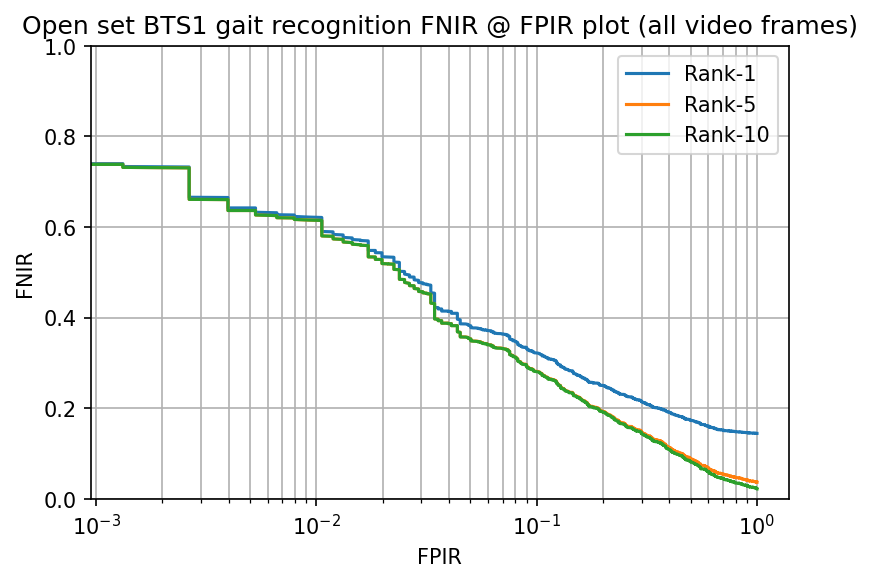

In [12]:
fig = plt.figure(facecolor='white', dpi=dpi)

for rr, rank in enumerate(ranks):
    plt.semilogx(fpirs[rr, :], fnirs[rr, :], label='Rank-{}'.format(rank))

plt.title('Open set BTS1 gait recognition FNIR @ FPIR plot (all video frames)')
plt.xlabel('FPIR')
plt.ylabel('FNIR')
plt.legend()
plt.grid(which='major')
plt.grid(which='minor')
plt.ylim([0, 1])
plt.show()


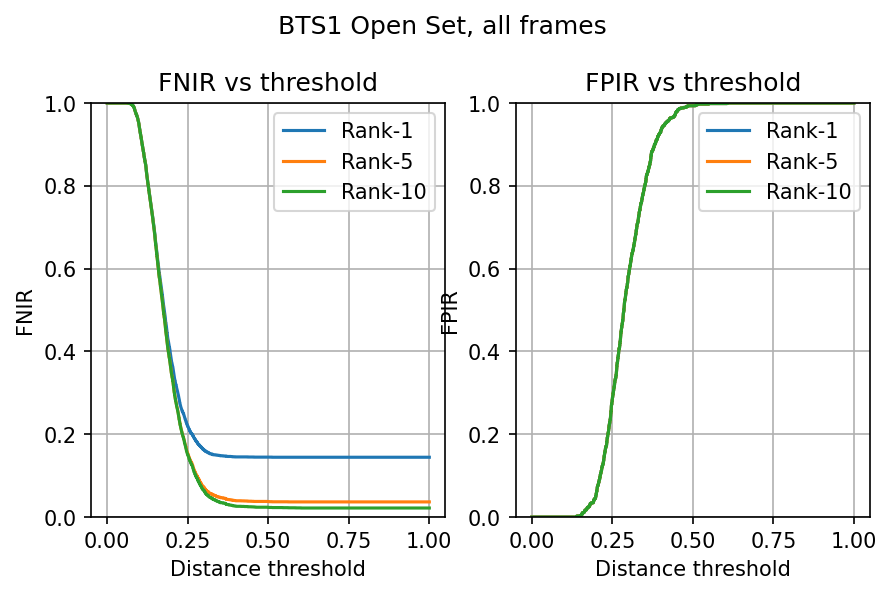

In [39]:
fig2 = plt.figure(facecolor='white', dpi=dpi)
fig2.suptitle('BTS1 Open Set, all frames')
plt.subplot(1, 2, 1)

for rr, rank in enumerate(ranks):
    plt.plot(cos_distance_thresholds, fnirs[rr, :], label='Rank-{}'.format(rank))

plt.tight_layout()
plt.title('FNIR vs threshold')
plt.xlabel('Distance threshold')
plt.ylabel('FNIR')
plt.legend()
plt.grid(which='major')
plt.grid(which='minor')
plt.ylim([0, 1])

plt.subplot(1, 2, 2)

for rr, rank in enumerate(ranks):
    plt.plot(cos_distance_thresholds, fpirs[rr, :], label='Rank-{}'.format(rank))


plt.tight_layout()
plt.title('FPIR vs threshold')
plt.xlabel('Distance threshold')
plt.ylabel('FPIR')
plt.legend()
plt.grid(which='major')
plt.grid(which='minor')
plt.ylim([0, 1])
plt.show()

